<a href="https://colab.research.google.com/github/JeffreyLuo333/ML-Notebooks/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this project, we will be building a machine learning model capable of recognizing dogs for self driving cars.

The first step to avoiding these dogs is **knowing if a puppy is in front of the car**. So today we will **build a detector that can tell when our car sees a dog or not**.



In [5]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Conv2D
from keras._tf_keras.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def one_hot_encoding(input):
  output = np.array(input)
  output = np.zeros((input.size, input.max()+1))
  output[np.arange(input.size),input] = 1

  return output


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));

  data   = data_dict['data']
  labels = data_dict['labels']

  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  fig, ax = plt.subplots(1,1)

  img = ax.imshow(my_img, extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)

def CNNClassifier(num_epochs=30, layers=4, dropout=0.5):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))

    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 7)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

ModuleNotFoundError: No module named 'keras._tf_keras.keras.wrappers'

In this notebook, we'll:
- Explore the cars vs. roads dataset
- Train a simple K-neighbors classifier for computer vision
- Train neural nets to tell dogs from roads
- Improve our model with convolutional neural networks!
- Use a saliency map to implement explainable AI

# Understanding our data

Our cars are very attentive and always have their eyes on the road.

Every second, they're streaming in data about the street, including video.

From this video data, we want our car to tell: is there 'road' or 'dog' in front of it?

Lucky for us, we have a dataset of dog and road images already prepared. Let's start by reading that *labeled* data in.


In [ ]:
# load our data
data, labels = load_data()

--2022-06-19 21:03:57--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.02s   

2022-06-19 21:03:57 (215 MB/s) - ‘cifar_data’ saved [3689015/3689015]



Let's look at an image of a dog.




label: dog


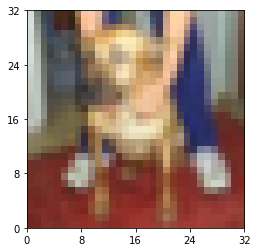

In [ ]:
plot_one_image(data, labels, 2) #change this number



Next, let's try a road image.

label: road


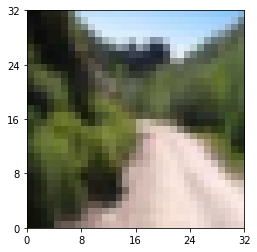

In [ ]:
plot_one_image(data, labels, 700) #change this number

How many images do we have?

In [ ]:
print (len(data))
print(Counter(labels))

1200
Counter({'dog': 600, 'road': 600})


The dataset is organized such that there are 600 images of dogs and 600 images of roads.

##Understanding our Data Representation

In an image each pixel is denoted by 3 numbers that represent the intensity value of that pixel (0 - 255) for each color channel (R, G, and B). Below we
see a list of numbers for each image that represent the intensity values.


In [ ]:
print('One image looks like: ')
print(data[0])
print("Length of list: ", len(data[0]))

One image looks like: 
[45 20 19 ... 83 99 31]
Length of list:  3072


We use these values as **inputs** to predict an **output** label: 'dog' or 'road'!

Here's what our entire dataset looks like:

In [ ]:
print ('Data shape:', data.shape)
print ('Data:', data)

Data shape: (1200, 3072)
Data: [[ 45  20  19 ...  83  99  31]
 [101 114  35 ... 155 134  91]
 [213 221 221 ... 139  58  47]
 ...
 [126 174 202 ... 124 128 129]
 [191 232 240 ...  74  93  81]
 [237 248 254 ...  45  56  10]]


#A Simple Machine Learner

We want to create a machine learning model that can tell us whether a new image is either a dog or a road.

We will give our model a training manual of data and labels that it will study or train on.

We then check how well our model is doing on a test, where it is given data and told to predict their labels.


##Building a KNN##

Let's start by using the `KNeighborsClassifier` model.

**Playground:** Explore [this demo](http://vision.stanford.edu/teaching/cs231n-demos/knn/) to understand what the KNN model is doing!



In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

# Initialize our model
knn_model = KNeighborsClassifier(n_neighbors=3) # Change this!

# Train our model
knn_model.fit(X_train,y_train)
# Test our model
y_pred = knn_model.predict(X_test)
# Print the score on the testing data
print(accuracy_score(y_test,y_pred))

0.8


##Predicting on images

We can use our trained model to predict whether our car is seeing a `dog` or `road`.


label: road
prediction: road


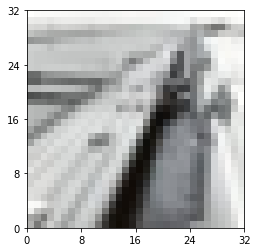

In [ ]:
# Specify which image you want to show
image_id = 100

# Visualize the image
plot_one_image(X_test, y_test, image_id)

# Use the model to predict what this might be and print it
print('prediction:', knn_model.predict([X_test[image_id]])[0])

## Choosing a value of k

Let's determine the optimal value of "K" for our data. We can use a for-loop to loop through different values of "K".

In [ ]:
for i in [1,3,5,10,20,30]:
  knn_model = KNeighborsClassifier(n_neighbors=i + 1)
  knn_model.fit(X_train,y_train)
  y_pred=knn_model.predict(X_test)
  print(accuracy_score(y_test,y_pred))

0.8916666666666667
0.8666666666666667
0.8375
0.8166666666666667
0.8041666666666667
0.8


## Understanding our mistakes

Our classifications are OK, but are they good enough for our conscientious cars?

Let's determine the root causes of the incorrect classifications.

TRUE POSITIVES
label: dog
label: dog
label: dog
label: dog
FALSE POSITIVES
label: road
TRUE NEGATIVES
label: road
label: road
label: road
label: road
FALSE NEGATIVES
label: dog
label: dog
label: dog
label: dog


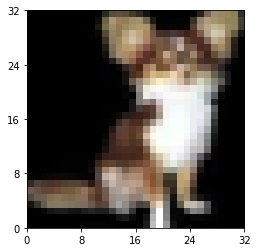

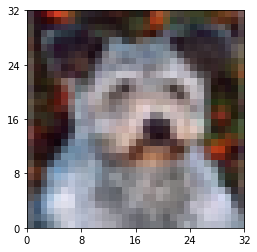

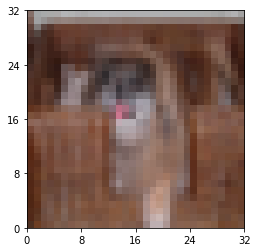

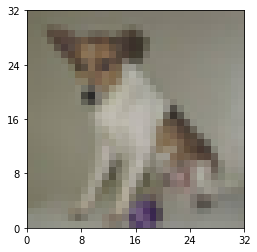

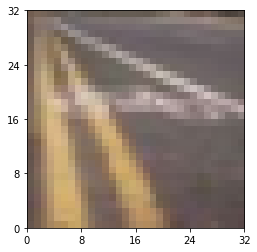

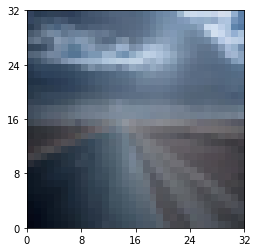

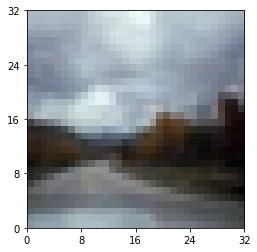

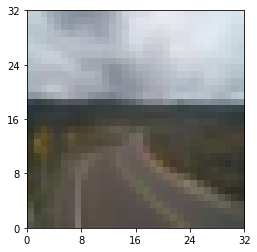

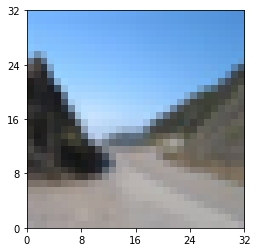

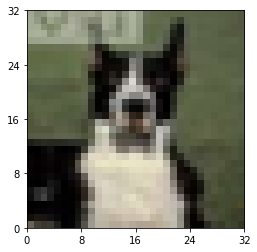

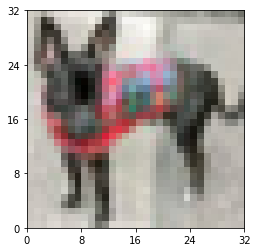

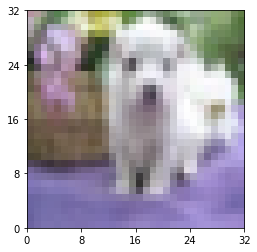

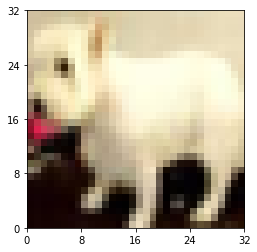

In [ ]:
#True Positives (code provided)
tp_count = 0
print ("TRUE POSITIVES")
i = 0
while tp_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction == y_test[i] and prediction == 'dog':
    plot_one_image(X_test, y_test, i)
    tp_count += 1
  i += 1

#False Positives
fp_count = 0
print ("FALSE POSITIVES")
i = 0
while fp_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction != y_test[i] and prediction == 'dog':
    plot_one_image(X_test, y_test, i)
    fp_count += 1
  i += 1
#True Negatives
tn_count = 0
print ("TRUE NEGATIVES")
i = 0
while tn_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction == y_test[i] and prediction == 'road':
    plot_one_image(X_test, y_test, i)
    tn_count += 1
  i += 1
#False Negatives
fn_count = 0
print ("FALSE NEGATIVES")
i = 0
while fn_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction != y_test[i] and prediction == 'road':
    plot_one_image(X_test, y_test, i)
    fn_count += 1
  i += 1

#Neural Networks
Now, let's create some new models using neural networks.

You can play around with [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to get a feel for how neural nets work.

To build a simple neural network, we use `MLPClassifier` from scikit-learn. We will play with the **number of neurons** and the **number of hidden layers** to adjust the complexity of our model, just like we did in Playground.

In [ ]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(3), random_state=1, max_iter=10000000)
nnet.fit(X_train, y_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(X_test)

# Print the score on the testing data
print("MLP Testing Accuracy:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Accuracy:
47.083333333333336


**How well did our neural network perform?**

Multilayer perceptrons are more complex models and it can be difficult to find the right "settings" for them. It takes some trial and error.


* Train a 1 layer, 10 neuron network for practice
* Change the number of neurons and/or add layers to see how well you can do
* Increase or decrease the number of iterations

In [ ]:
nnet = MLPClassifier(hidden_layer_sizes=(10,10), random_state=1, max_iter=10000000)
nnet.fit(X_train, y_train)
predictions = nnet.predict(X_test)
print("MLP Testing Accuracy:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Accuracy:
87.91666666666667


###Automating our Experiments

Similar to what we did for KNNs, we can use a for loop to automate our investigation.

In [ ]:
for i in [(1,1), (3,3), (5,5), (8,6), (10,10,10), (10,10,5)]:
  nnet = MLPClassifier(hidden_layer_sizes=i, random_state=1, max_iter=10000000)
  nnet.fit(X_train, y_train)
  predictions = nnet.predict(X_test)
  print("MLP Testing Accuracy:")
  print(accuracy_score(y_test, predictions)*100)

MLP Testing Accuracy:
47.083333333333336
MLP Testing Accuracy:
47.083333333333336
MLP Testing Accuracy:
52.916666666666664
MLP Testing Accuracy:
44.166666666666664
MLP Testing Accuracy:
52.916666666666664
MLP Testing Accuracy:
87.5


# Models for Vision: Convolutional Neural Networks
There is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out.

###Training Your CNN
To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs=N)`

The `num_epochs` represents how many times the neural network passes through the training dataset.

We'll need to change our data to floats (decimal numbers).

In [ ]:
# convert our data to floats for our CNN
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Create and train our cnn
cnn = CNNClassifier(num_epochs=40)
cnn.fit(X_train,y_train)
# Predict what the classes are based on the testing data
y_pred=cnn.predict(X_test)
# Print the score on the testing data
print(accuracy_score(y_test,y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/40
96/96 - 13s - loss: 1.9257 - accuracy: 0.6073 - 13s/epoch - 138ms/step
Epoch 2/40
96/96 - 0s - loss: 0.4921 - accuracy: 0.8010 - 467ms/epoch - 5ms/step
Epoch 3/40
96/96 - 0s - loss: 0.3425 - accuracy: 0.8615 - 481ms/epoch - 5ms/step
Epoch 4/40
96/96 - 0s - loss: 0.3014 - accuracy: 0.8844 - 481ms/epoch - 5ms/step
Epoch 5/40
96/96 - 0s - loss: 0.2785 - accuracy: 0.8865 - 490ms/epoch - 5ms/step
Epoch 6/40
96/96 - 0s - loss: 0.2503 - accuracy: 0.9042 - 467ms/epoch - 5ms/step
Epoch 7/40
96/96 - 0s - loss: 0.2615 - accuracy: 0.9052 - 479ms/epoch - 5ms/step
Epoch 8/40
96/96 - 0s - loss: 0.1882 - accuracy: 0.9167 - 480ms/epoch - 5ms/step
Epoch 9/40
96/96 - 1s - loss: 0.1970 - accuracy: 0.9333 - 500ms/epoch - 5ms/step
Epoch 10/40
96/96 - 0s - loss: 0.1758 - accuracy: 0.9344 - 478ms/epoch - 5ms/step
Epoch 11/40
96/96 - 0s - loss: 0.1499 - accuracy: 0.9458 - 500ms/epoch - 5ms/step
Epoch 12/40
96/96 - 0s - loss: 0.1682 - accuracy: 0.9344 - 483ms/epoch - 5ms/step
Epoch 13/40
96/96 - 0s -

CNNs typically perform better than basic Neural Networks on vision problems - but like basic Neural Networks, they aren't always consistent in their results and are sensitive to a number of factors.

If you're interested in learning more about CNNs, spend some time exploring the [CNN Explainer](https://poloclub.github.io/cnn-explainer/)!


## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. **How do you know when your model is overfitting?**

To plot our model's history, we can train it with
```
history = model.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))
```

and then use
```
plot_acc(history)
```


**After how many epochs does the model begin to overfit?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

Epoch 1/90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


96/96 - 2s - loss: 2.9680 - accuracy: 0.6031 - val_loss: 0.4062 - val_accuracy: 0.7958 - 2s/epoch - 20ms/step
Epoch 2/90
96/96 - 1s - loss: 0.5485 - accuracy: 0.7927 - val_loss: 0.2035 - val_accuracy: 0.9167 - 560ms/epoch - 6ms/step
Epoch 3/90
96/96 - 1s - loss: 0.3835 - accuracy: 0.8531 - val_loss: 0.2598 - val_accuracy: 0.8875 - 558ms/epoch - 6ms/step
Epoch 4/90
96/96 - 1s - loss: 0.2671 - accuracy: 0.8979 - val_loss: 0.2001 - val_accuracy: 0.9250 - 561ms/epoch - 6ms/step
Epoch 5/90
96/96 - 1s - loss: 0.2724 - accuracy: 0.8917 - val_loss: 0.1788 - val_accuracy: 0.9583 - 570ms/epoch - 6ms/step
Epoch 6/90
96/96 - 1s - loss: 0.2533 - accuracy: 0.9000 - val_loss: 0.1566 - val_accuracy: 0.9458 - 847ms/epoch - 9ms/step
Epoch 7/90
96/96 - 1s - loss: 0.2171 - accuracy: 0.9281 - val_loss: 0.1862 - val_accuracy: 0.9208 - 1s/epoch - 11ms/step
Epoch 8/90
96/96 - 1s - loss: 0.1933 - accuracy: 0.9208 - val_loss: 0.2157 - val_accuracy: 0.9083 - 647ms/epoch - 7ms/step
Epoch 9/90
96/96 - 1s - loss: 0

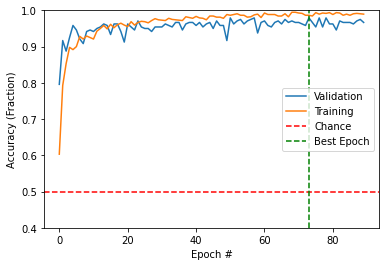

In [ ]:
model=CNNClassifier(num_epochs=90)
history = model.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))
plot_acc(history)